In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [155]:
from src.tmdb_model import tmdb_model
from src.tmdb_linreg import tmdb_linreg

In [156]:
releases = pd.read_csv('../02_Data/2B_data-output.csv', usecols=['id', 'release'])
data = pd.read_csv('../02_Data/2B_data-output_10.27.1700.csv')
data = data.merge(releases)

In [157]:
data.head(2)

,id,opening_revenue,budget,runtime,position_in_series,previous_film_release,previous_film_rating,cast_xp_median,cast_rating_max,writer_xp_median,...,is_jun,is_jul,is_aug,is_sep,is_oct,is_nov,is_dec,first_time_writers,first_time_directors,release
0,59,364000.0,32000000.0,96.0,1,0.0,0.0,43.0,8.500,3.5,...,0,0,0,1,0,0,0,0,0,A History of Violence
1,8976,7576593.0,30000000.0,107.0,1,0.0,0.0,12.0,7.574,0.0,...,0,0,0,0,0,0,0,1,0,A Lot Like Love


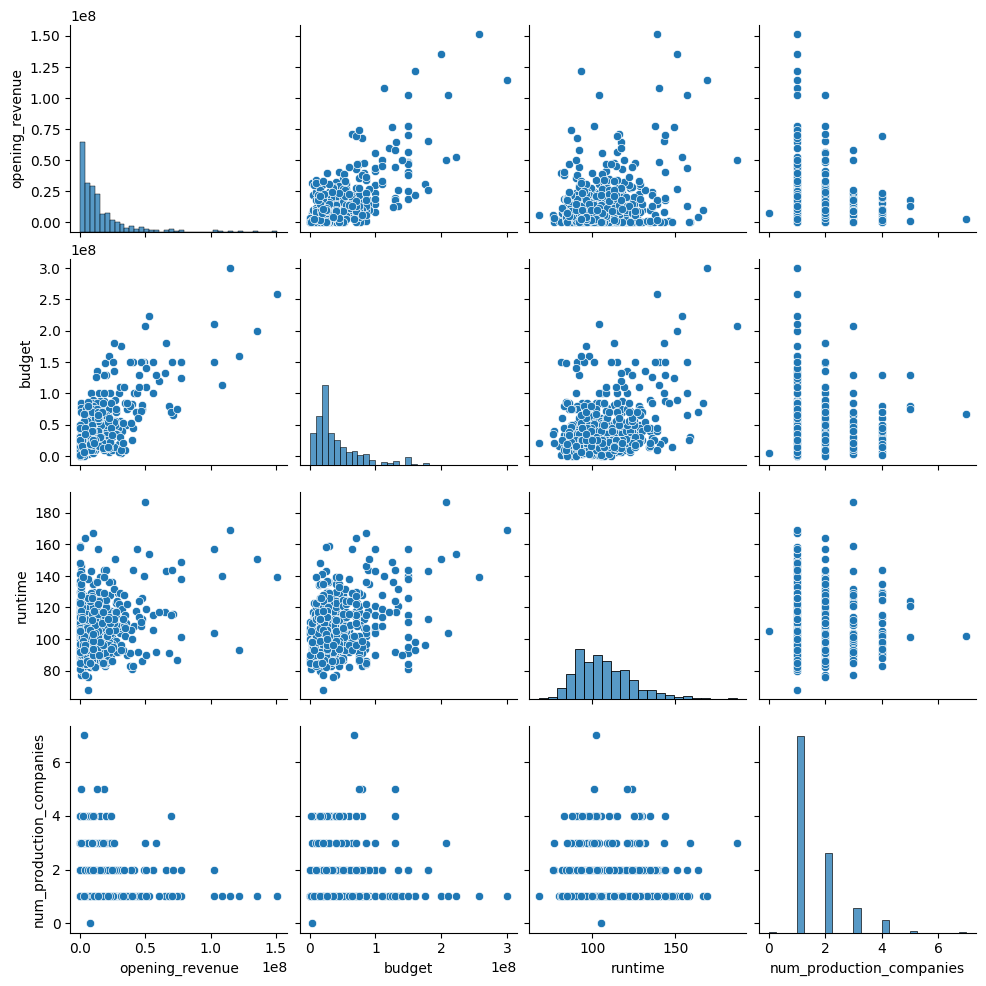

In [158]:
sns.pairplot(data[['opening_revenue', 'budget', 'runtime', 'num_production_companies']])
plt.show();

                             OLS Regression Results                             
Dep. Variable:     sqrt_opening_revenue   R-squared:                       0.550
Model:                              OLS   Adj. R-squared:                  0.543
Method:                   Least Squares   F-statistic:                     76.74
Date:                  Mon, 28 Oct 2024   Prob (F-statistic):           3.79e-82
Time:                          16:19:01   Log-Likelihood:                -4428.8
No. Observations:                   511   AIC:                             8876.
Df Residuals:                       502   BIC:                             8914.
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2998.0409    4

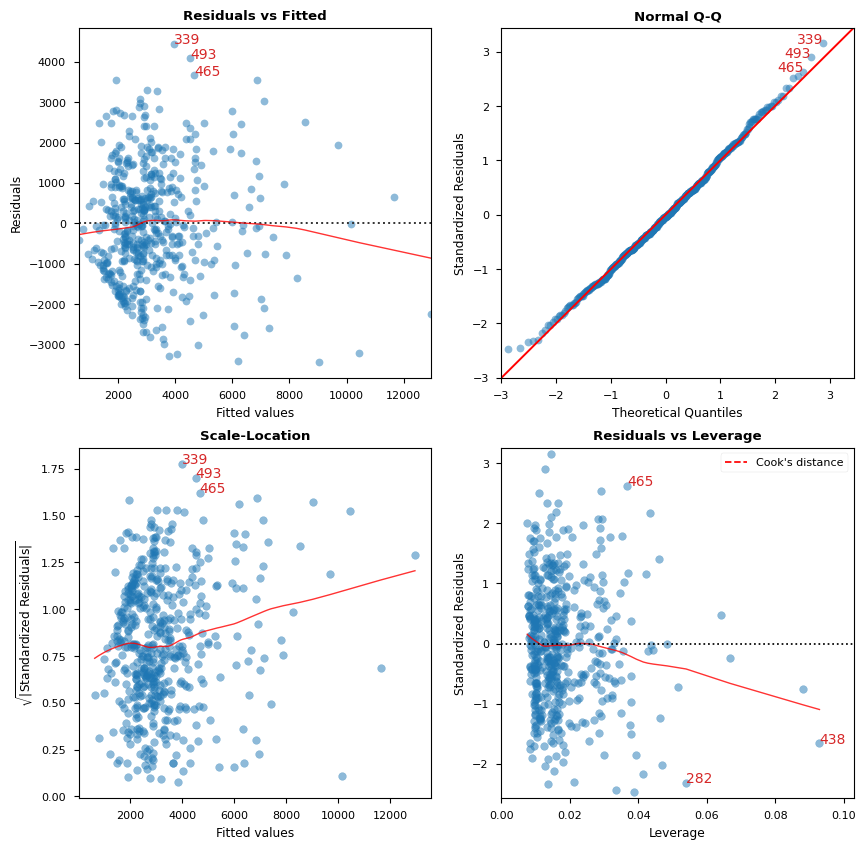

In [159]:
# Initialize TMDB model class.
mdl = tmdb_model()
cdf = data
cdf['num_prod_cos'] = cdf['num_production_companies']

# Generate OLS model.
Y = ['opening_revenue']
X = ['budget', 'is_series', 'num_prod_cos', 'runtime', 'is_spring',
       'is_summer', 'is_fall', 'is_holiday']

cov_transform = {'opening_revenue': 'sqrt'}
cov_joint = None

_, res = mdl.get_ols_model(cdf, Y, X, cov_transform=cov_transform, cov_joint=cov_joint)

# Generate linear regression diagnostics for OLS model.
print(res.summary())

diag = tmdb_linreg(res)
vif, fig, ax = diag()

In [160]:
print(res.summary().tables[1].as_latex_tabular())

\begin{center}
\begin{tabular}{lcccccc}
\toprule
                        & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}          &    2998.0409  &      440.927     &     6.799  &         0.000        &     2131.750    &     3864.331     \\
\textbf{budget}         &    3.302e-05  &     1.77e-06     &    18.651  &         0.000        &     2.95e-05    &     3.65e-05     \\
\textbf{is\_series}     &    1222.4619  &      204.619     &     5.974  &         0.000        &      820.446    &     1624.478     \\
\textbf{num\_prod\_cos} &    -279.2880  &       71.525     &    -3.905  &         0.000        &     -419.814    &     -138.762     \\
\textbf{runtime}        &      -2.6500  &        4.062     &    -0.652  &         0.514        &      -10.630    &        5.330     \\
\textbf{is\_spring}     &    -305.6452  &      230.176     &    -1.328  &         0.185        &     -757.873    &      146.582     \

In [161]:
dffits = diag.dffits(releases=data['release'])
dffits.head(10)
#print(dffits.head(10).to_latex(index=True, float_format="%.2f"))

,release,dffits
282,Superman Returns,-0.556751
438,Pirates of the Caribbean: At World's End,-0.531926
465,The Bourne Ultimatum,0.517027
380,Evan Almighty,-0.497935
47,Harry Potter and the Goblet of Fire,0.465584
102,Son of the Mask,-0.457568
178,Basic Instinct 2,-0.453728
238,Letters from Iwo Jima,-0.451512
103,Star Wars: Episode III - Revenge of the Sith,0.444417
339,300,0.385090


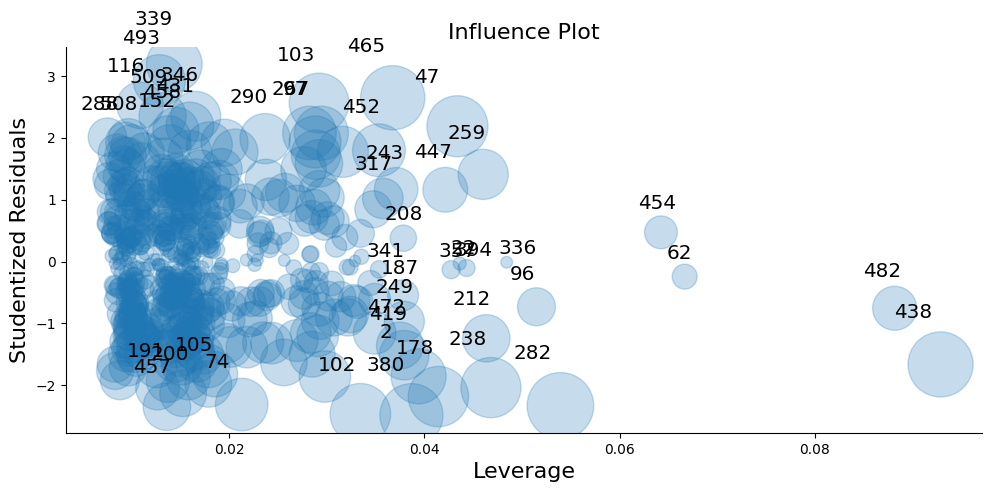

In [162]:
# potential influence points are numbered / called out
# match to the previous table based on the index
fig, ax = plt.subplots(figsize=(10, 5))
sm.graphics.influence_plot(diag.results, criterion="dffits", ax=ax, plot_alpha=0.25)
fig.tight_layout(pad=1.0)
sns.despine()
plt.show()

In [163]:
# Outlier observations affecting constant (0th coefficient)
dfbetas = diag.dfbetas(releases=data['release'], coef=0)
dfbetas.head(10)

,release,dfbetas
47,Harry Potter and the Goblet of Fire,-0.222969
238,Letters from Iwo Jima,0.187599
103,Star Wars: Episode III - Revenge of the Sith,-0.187117
493,The Simpsons Movie,0.183022
282,Superman Returns,0.175503
102,Son of the Mask,-0.169450
74,Memoirs of a Geisha,0.162426
290,The Da Vinci Code,-0.157537
438,Pirates of the Caribbean: At World's End,0.152138
380,Evan Almighty,-0.146612


In [172]:
# Outlier observations affecting budget (1st coefficient)
dfbetas_budget = diag.dfbetas(releases=data['release'], coef=1)
out = pd.merge(dfbetas_budget, data['budget'].div(1E6), left_index=True, right_index=True).head(10)
out
#print(out.to_latex(index=True, float_format="%.2f"))

,release,dfbetas,budget
438,Pirates of the Caribbean: At World's End,-0.365118,300.0
380,Evan Almighty,-0.330195,175.0
282,Superman Returns,-0.309080,223.0
260,Poseidon,-0.278296,160.0
401,I Am Legend,0.241586,150.0
419,Meet the Robinsons,-0.241131,150.0
238,Letters from Iwo Jima,0.229161,19.0
212,Flushed Away,-0.228124,149.0
472,The Golden Compass,-0.216335,180.0
452,Shrek the Third,0.210244,160.0


In [165]:
# Outlier observations affecting is_series (2nd coefficient)
dfbetas_series = diag.dfbetas(releases=data['release'], coef=2)
out = pd.merge(dfbetas_series, data['is_series'], left_index=True, right_index=True).head(10)
out
#print(out.to_latex(index=True, float_format="%.2f"))

,release,dfbetas,is_series
465,The Bourne Ultimatum,0.327336,1
238,Letters from Iwo Jima,-0.314397,1
267,Saw III,0.287603,1
102,Son of the Mask,-0.287147,1
103,Star Wars: Episode III - Revenge of the Sith,0.287119,1
97,Saw II,0.283698,1
178,Basic Instinct 2,-0.263073,1
449,Saw IV,0.260318,1
47,Harry Potter and the Goblet of Fire,0.251571,1
230,Jackass Number Two,0.231541,1


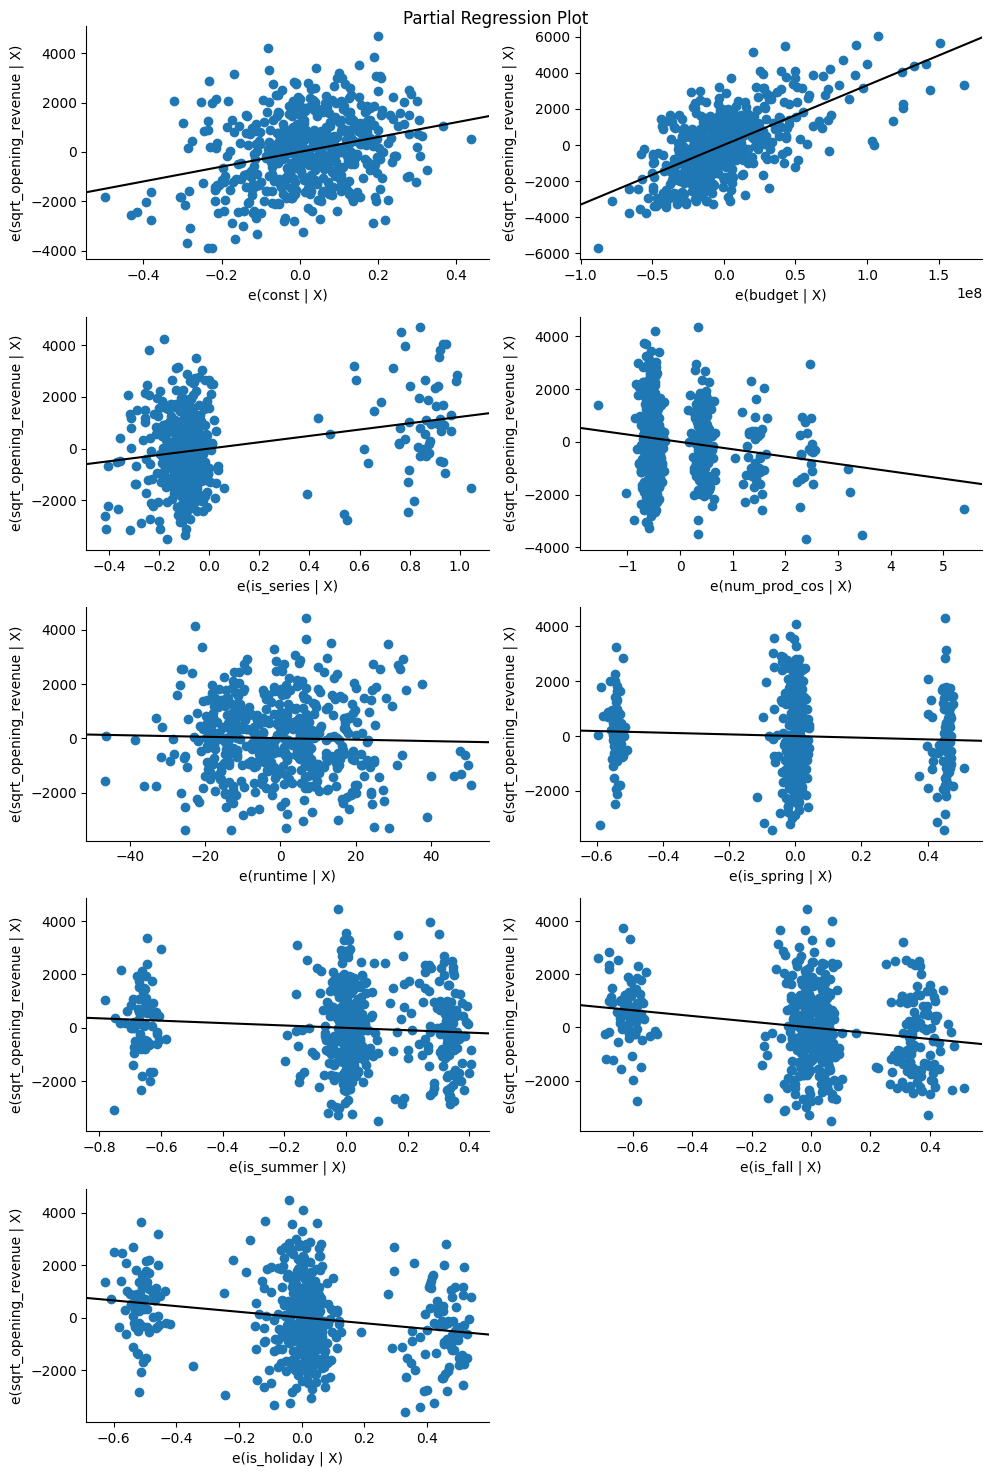

In [166]:
# Partial regression plots, aka added variable plots
# Since in multivariate regression, cannot just look at individual bivariate plots
# Visualize the relationship between the response variable and the k-th variable
# Regress response variable vs. independent variables, excluding X_k. Denote the residuals X_~k.
# Then regress X_k on 
fig = plt.figure(figsize=(10, 15))
sm.graphics.plot_partregress_grid(res, fig=fig)
fig.tight_layout(pad=1.0)
sns.despine()
plt.show();

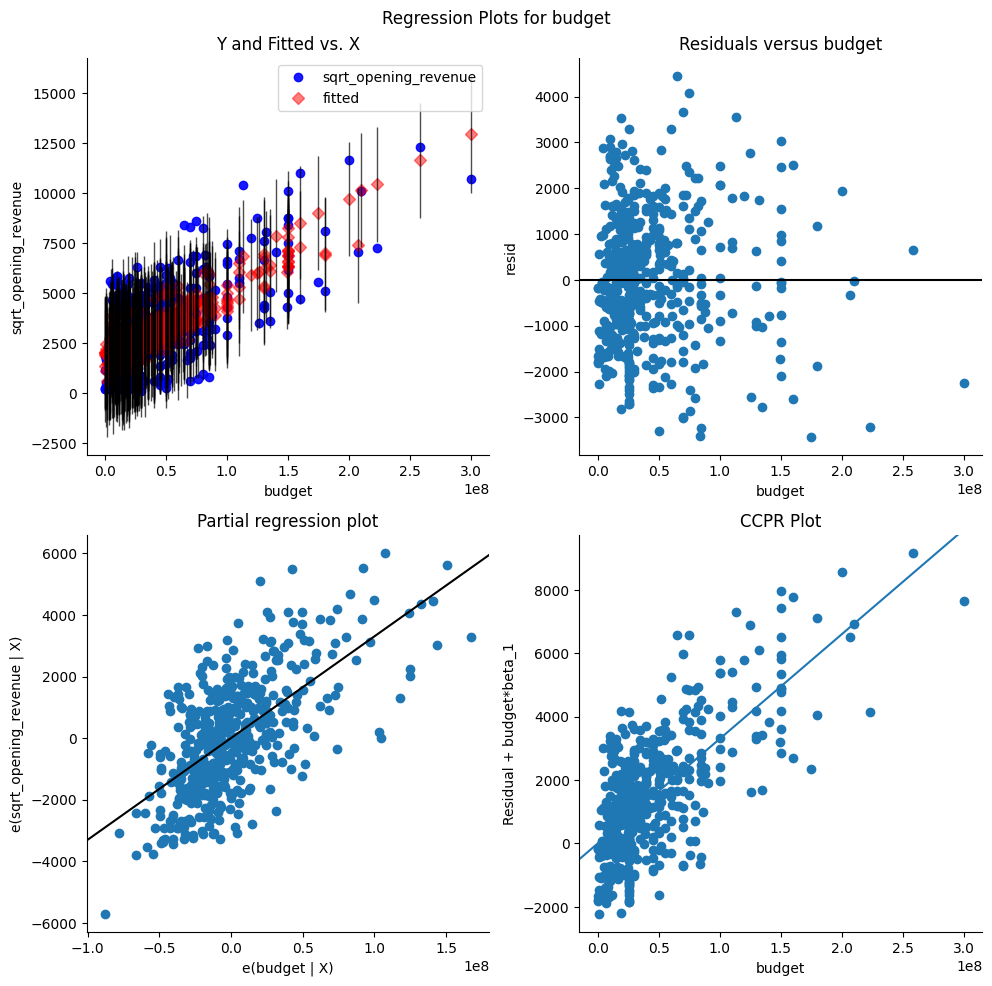

In [167]:
fig = plt.figure(figsize=(10, 10))
sm.graphics.plot_regress_exog(res, "budget", fig=fig)
fig.tight_layout(pad=1.0)
sns.despine()
plt.show();

In [168]:
vif['VIF Factor'].mean().round()

7.0

In [169]:
# Check how much coefficient changes based on dropping observation with highest (asbolute) DFBETA
mdl = tmdb_model()
cdf = data.drop(dfbetas_budget.index[0], axis=0)

# Generate OLS model.
Y = ['opening_revenue']
X = ['budget', 'is_series', 'num_production_companies', 'runtime', 'is_spring',
       'is_summer', 'is_fall', 'is_holiday']

cov_transform = {'opening_revenue': 'sqrt'}
cov_joint = None

_, res = mdl.get_ols_model(cdf, Y, X, cov_transform=cov_transform, cov_joint=cov_joint)
print(res.summary()) # budget coefficient increases from 3.302e-05 to 3.366e-05

                             OLS Regression Results                             
Dep. Variable:     sqrt_opening_revenue   R-squared:                       0.541
Model:                              OLS   Adj. R-squared:                  0.534
Method:                   Least Squares   F-statistic:                     73.84
Date:                  Mon, 28 Oct 2024   Prob (F-statistic):           7.80e-80
Time:                          16:19:03   Log-Likelihood:                -4419.2
No. Observations:                   510   AIC:                             8856.
Df Residuals:                       501   BIC:                             8895.
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
cons

In [170]:
# Check how much is_series coefficient changes dropping observation with highest (asbolute) DFBETA
mdl = tmdb_model()
cdf = data.drop(dfbetas_series.index[0:1], axis=0)

# Generate OLS model.
Y = ['opening_revenue']
X = ['budget', 'is_series', 'num_production_companies', 'runtime', 'is_spring',
       'is_summer', 'is_fall', 'is_holiday']

cov_transform = {'opening_revenue': 'sqrt'}
cov_joint = None

_, res = mdl.get_ols_model(cdf, Y, X, cov_transform=cov_transform, cov_joint=cov_joint)
print(res.summary()) # is_series coefficient changes from 1222.4619 to 1155.8795

                             OLS Regression Results                             
Dep. Variable:     sqrt_opening_revenue   R-squared:                       0.551
Model:                              OLS   Adj. R-squared:                  0.544
Method:                   Least Squares   F-statistic:                     76.89
Date:                  Mon, 28 Oct 2024   Prob (F-statistic):           3.27e-82
Time:                          16:19:03   Log-Likelihood:                -4417.1
No. Observations:                   510   AIC:                             8852.
Df Residuals:                       501   BIC:                             8890.
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
cons

In [171]:
# Check how much coefficients change dropping DFFITs observations
mdl = tmdb_model()
cdf = data.drop(dffits.index, axis=0)

# Generate OLS model.
Y = ['opening_revenue']
X = ['budget', 'is_series', 'num_production_companies', 'runtime', 'is_spring',
       'is_summer', 'is_fall', 'is_holiday']

cov_transform = {'opening_revenue': 'sqrt'}
cov_joint = None

_, res = mdl.get_ols_model(cdf, Y, X, cov_transform=cov_transform, cov_joint=cov_joint)
print(res.summary()) 

                             OLS Regression Results                             
Dep. Variable:     sqrt_opening_revenue   R-squared:                       0.563
Model:                              OLS   Adj. R-squared:                  0.555
Method:                   Least Squares   F-statistic:                     75.57
Date:                  Mon, 28 Oct 2024   Prob (F-statistic):           1.60e-79
Time:                          16:19:03   Log-Likelihood:                -4087.1
No. Observations:                   479   AIC:                             8192.
Df Residuals:                       470   BIC:                             8230.
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
cons